In [1]:
#加载飞桨、Numpy和相关类库
import paddle
import paddle.fluid as fluid
import paddle.fluid.dygraph as dygraph
from paddle.fluid.dygraph import Linear
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [2]:
def load_data():
    # 读入训练数据
    datafile = pd.read_csv('./data/housing.csv')
    data = datafile.iloc[:,:].values
    feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE','DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
    feature_num = len(feature_names)

    # 将原数据集拆分成训练集和测试集
    # 这里使用80%的数据做训练，20%的数据做测试
    # 测试集和训练集必须是没有交集的
    ratio = 0.8
    offset = int(data.shape[0] * ratio)
    training_data = data[:offset]

    # 计算train数据集的最大值，最小值，平均值
    maximums, minimums, avgs = training_data.max(axis=0), training_data.min(axis=0), \
                                 training_data.sum(axis=0) / training_data.shape[0]
    
    # 记录数据的归一化参数，在预测时对数据做归一化
    global max_values
    global min_values
    global avg_values
    max_values = maximums
    min_values = minimums
    avg_values = avgs

    # 对数据进行归一化处理
    for i in range(feature_num):
        data[:, i] = (data[:, i] - avgs[i]) / (maximums[i] - minimums[i])

    # 训练集和测试集的划分比例
    training_data = data[:offset]
    test_data = data[offset:]
    return training_data, test_data

In [3]:
class Regressor(fluid.dygraph.Layer):

    # self代表类的实例自身
    def __init__(self,name_scope):
        # 初始化父类中的一些参数
        super(Regressor, self).__init__(name_scope)
        name_scope = self.full_name()
        # 定义2层全连接层，输入维度是13，输出维度是1
        self.fc1 = Linear(input_dim=13, output_dim=4, act='relu')
        self.fc2 = Linear(input_dim=4, output_dim=1,act=None)
    
    # 网络的前向计算
    def forward(self, inputs):
        x = self.fc1(inputs)
        x = self.fc2(x)
        return x

In [4]:
with fluid.dygraph.guard():
    model = Regressor("Regressor")
    model.train()
    training_data, test_data = load_data()
    # 随机梯度下降
    opt = fluid.optimizer.SGD(learning_rate=0.01,parameter_list=model.parameters())

In [5]:
with dygraph.guard(fluid.CPUPlace()):
    EPOCH_NUM = 1000   # 设置外层循环次数
    BATCH_SIZE = 10  # 设置batch大小

    # 定义外层循环
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(training_data)
        # 将训练数据进行拆分，每个batch包含10条数据
        mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
        # 定义内层循环
        for iter_id, mini_batch in enumerate(mini_batches):
            x = np.array(mini_batch[:, :-1]).astype('float32') # 获得当前批次训练数据
            y = np.array(mini_batch[:, -1:]).astype('float32') # 获得当前批次训练标签（真实房价）
            # 将numpy数据转为飞桨动态图variable形式
            house_features = dygraph.to_variable(x)
            prices = dygraph.to_variable(y)
        
            # 前向计算
            predicts = model(house_features)
        
            # 计算损失
            loss = fluid.layers.square_error_cost(predicts, label=prices)
            avg_loss = fluid.layers.mean(loss)
            if iter_id % 20 == 0:
                print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_loss.numpy()))
        
            # 反向传播
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.minimize(avg_loss)
            # 清除梯度
            model.clear_gradients()
    
    # 保存模型参数，文件名为LR_model
    fluid.save_dygraph(model.state_dict(), 'LR_model')

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(obj, collections.Iterator):
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2366: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  return list(data) if isinstance(data, collections.MappingView) else data


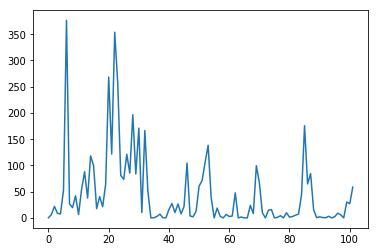

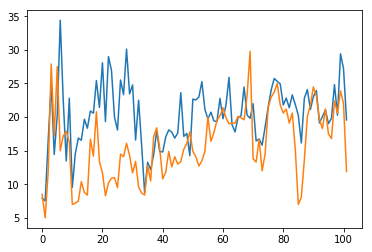

In [6]:
with dygraph.guard():
    # 参数为保存模型参数的文件地址
    model_dict = paddle.load('LR_model.pdparams')
    model.load_dict(model_dict)
    model.eval()
    
    label = np.array(test_data[:,-1:]).astype(np.float32)
    one_data = np.array(test_data[:,:-1]).astype(np.float32)
        
    # 将数据转为动态图的variable格式 
    one_data = dygraph.to_variable(one_data)
    label = dygraph.to_variable(label)
    results = model(one_data)
    
    results = results * (max_values[-1] - min_values[-1]) + avg_values[-1]
    label = label * (max_values[-1] - min_values[-1]) + avg_values[-1]

    loss = fluid.layers.square_error_cost(results, label=label)
    avg_loss = fluid.layers.mean(loss)
    #print(loss.numpy())
    #print(results.numpy())
    
    plt.figure(1)
    plt.plot(loss.numpy())
    plt.show()
    
    plt.figure(2)
    plt.plot(results.numpy())
    plt.plot(label.numpy())
    plt.show()